In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

In [11]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

In [3]:
# Get the path to the normal and pneumonia sub-directories
train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# train_data = train_data.sample(frac=1., random_state=0).reset_index(drop=True)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\NORMAL\NORMAL2-IM-1342-0001.jpeg,0
1,chest_xray\train\PNEUMONIA\person490_virus_996...,1
2,chest_xray\train\PNEUMONIA\person1312_bacteria...,1
3,chest_xray\train\PNEUMONIA\person266_bacteria_...,1
4,chest_xray\train\PNEUMONIA\person25_bacteria_1...,1


In [4]:
# Get the path to the normal and pneumonia sub-directories
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# test_data = test_data.sample(frac=1., random_state=0).reset_index(drop=True)
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,chest_xray\test\PNEUMONIA\person1640_virus_283...,1
1,chest_xray\test\PNEUMONIA\person53_virus_107.jpeg,1
2,chest_xray\test\PNEUMONIA\person67_virus_126.jpeg,1
3,chest_xray\test\PNEUMONIA\person79_virus_148.jpeg,1
4,chest_xray\test\NORMAL\IM-0071-0001.jpeg,0


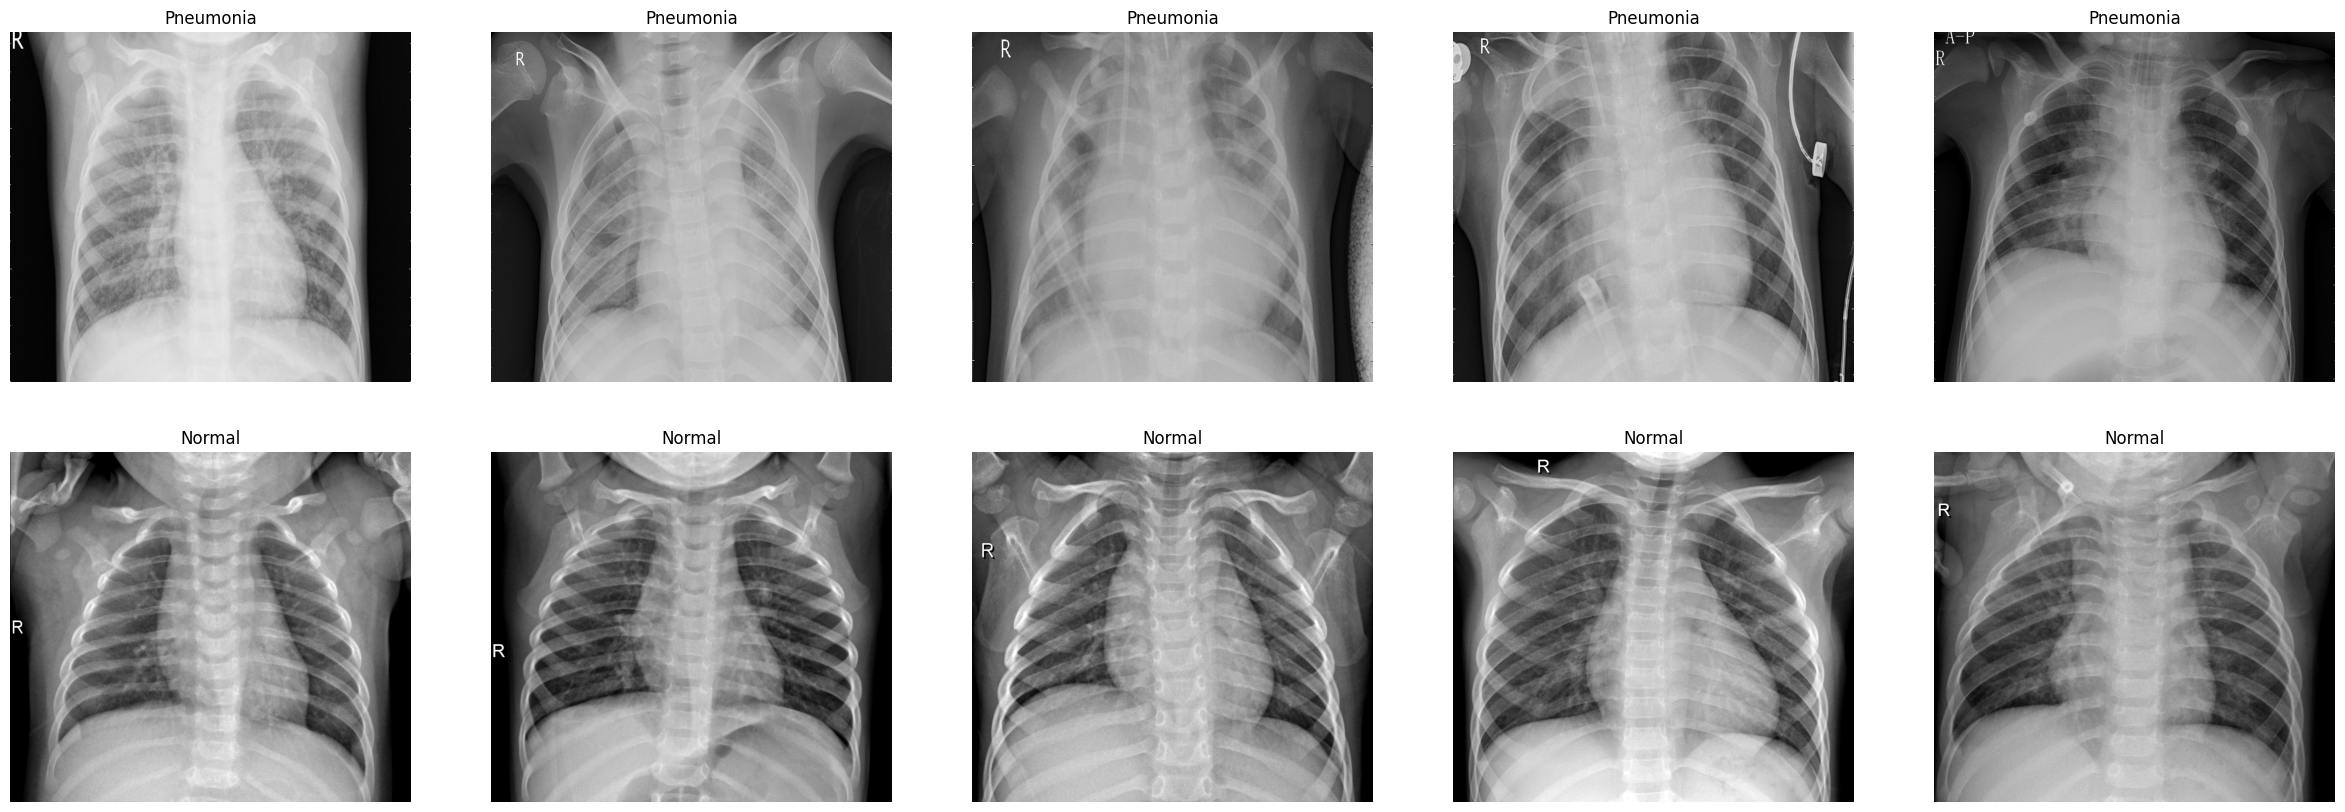

In [5]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

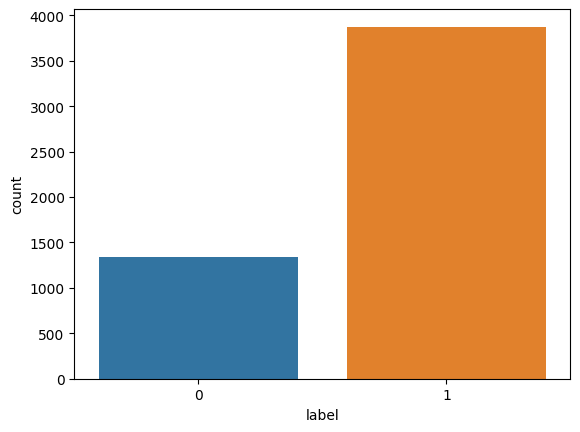

In [6]:
sns.countplot(data=train_data, x='label')
plt.show()

### Inference
1. Our dataset is unbalanced. We have much lesser normal cases that pneumonia cases. 
2. We will calculate the number of normal cases and take the same number of normal and pneumonia cases

In [7]:
len(train_data[train_data['label']==0])

1341

In [8]:
train_data_balanced = []

for img in train_data[train_data['label']==1][:1300]['image']:
    train_data_balanced.append((img,1))

for img in train_data[train_data['label']==0][:1300]['image']:
    train_data_balanced.append((img,0))

# Get a pandas dataframe from the data we have in our list 
train_data_balanced = pd.DataFrame(train_data_balanced, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data_balanced = train_data_balanced.sample(frac=1., random_state=0).reset_index(drop=True)

# How the dataframe looks like?
train_data_balanced.head()

,image,label
0,chest_xray\train\PNEUMONIA\person313_virus_637...,1
1,chest_xray\train\NORMAL\NORMAL2-IM-0508-0001.jpeg,0
2,chest_xray\train\NORMAL\NORMAL2-IM-1315-0001.jpeg,0
3,chest_xray\train\PNEUMONIA\person1077_bacteria...,1
4,chest_xray\train\NORMAL\NORMAL2-IM-1285-0001.jpeg,0


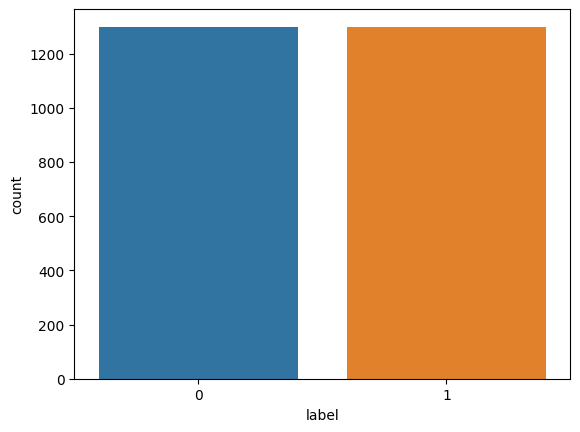

In [9]:
sns.countplot(data=train_data_balanced, x='label')
plt.show()

In [10]:
sizes = []
for imgPath in train_data_balanced['image']:
    img = imread(imgPath)
    size = img.shape
    sizes.append(size)

train_data_balanced['size'] = sizes
train_data_balanced

,image,label,size
0,chest_xray\train\PNEUMONIA\person313_virus_637...,1,"(640, 992)"
1,chest_xray\train\NORMAL\NORMAL2-IM-0508-0001.jpeg,0,"(1066, 1422)"
2,chest_xray\train\NORMAL\NORMAL2-IM-1315-0001.jpeg,0,"(1295, 1858)"
3,chest_xray\train\PNEUMONIA\person1077_bacteria...,1,"(640, 1048)"
4,chest_xray\train\NORMAL\NORMAL2-IM-1285-0001.jpeg,0,"(2169, 1962)"
...,...,...,...
2595,chest_xray\train\PNEUMONIA\person938_bacteria_...,1,"(672, 920)"
2596,chest_xray\train\NORMAL\IM-0693-0001.jpeg,0,"(932, 1118)"
2597,chest_xray\train\PNEUMONIA\person1228_virus_20...,1,"(600, 1000)"
2598,chest_xray\train\PNEUMONIA\person589_bacteria_...,1,"(672, 1096)"


In [11]:
ratios = []
lengths = []
for size in train_data_balanced['size']:
  length = size[1] * size[0]
  ratio = size[1] / size[0]
  lengths.append(length)
  ratios.append(ratio)

train_data_balanced['length'] = lengths
train_data_balanced['ratio'] = ratios
train_data_balanced

,image,label,size,length,ratio
0,chest_xray\train\PNEUMONIA\person313_virus_637...,1,"(640, 992)",634880,1.550000
1,chest_xray\train\NORMAL\NORMAL2-IM-0508-0001.jpeg,0,"(1066, 1422)",1515852,1.333959
2,chest_xray\train\NORMAL\NORMAL2-IM-1315-0001.jpeg,0,"(1295, 1858)",2406110,1.434749
3,chest_xray\train\PNEUMONIA\person1077_bacteria...,1,"(640, 1048)",670720,1.637500
4,chest_xray\train\NORMAL\NORMAL2-IM-1285-0001.jpeg,0,"(2169, 1962)",4255578,0.904564
...,...,...,...,...,...
2595,chest_xray\train\PNEUMONIA\person938_bacteria_...,1,"(672, 920)",618240,1.369048
2596,chest_xray\train\NORMAL\IM-0693-0001.jpeg,0,"(932, 1118)",1041976,1.199571
2597,chest_xray\train\PNEUMONIA\person1228_virus_20...,1,"(600, 1000)",600000,1.666667
2598,chest_xray\train\PNEUMONIA\person589_bacteria_...,1,"(672, 1096)",736512,1.630952


In [12]:
train_data_balanced.describe()

,label,length,ratio
count,2600.000000,2.600000e+03,2600.000000
mean,0.500000,1.726135e+06,1.372331
std,0.500096,1.064578e+06,0.252635
min,0.000000,4.876800e+04,0.877220
25%,0.000000,9.019840e+05,1.199934
50%,0.500000,1.556576e+06,1.325102
75%,1.000000,2.272892e+06,1.502722
max,1.000000,7.532028e+06,3.271523


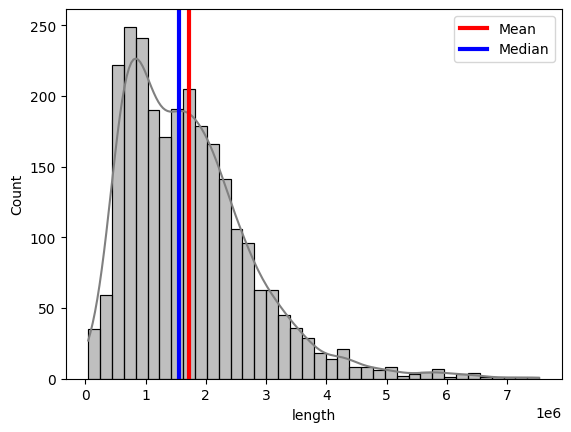

In [13]:
sns.histplot(data=train_data_balanced, x='length', color='gray', kde=True)
plt.axvline(train_data_balanced['length'].mean(), color='red', lw=3, label="Mean")
plt.axvline(train_data_balanced['length'].median(), color='blue', lw=3, label="Median")
plt.legend()
plt.show()

We will find the vector length and find the dimension to which we should resize all images

In [14]:
length = train_data_balanced['length'].min()
print(length)

# We will rescale all images into x*x images
x = int(np.sqrt(length))
x

48768


220

In [15]:
def makeDataset(data):
    dataset = ""
    for location in data:
        # reading the image from location
        img = imread(location)
        
        # turning rgb images to grayscale
        if len(img.shape) == 3:
            img = rgb2gray(img)

        # resizing to our desired size and scaling it to 255
        img = resize(img, (x, x), anti_aliasing=True) * 255

        # converting to uint8 for saving memory
        img = img.astype(np.uint8)

        # converting to vector
        img = img.reshape(-1)

        # initiating dataset or vstacking onto dataset
        if type(dataset) == str:
            dataset = img
        else:
            dataset = np.vstack([dataset, img])

    # returning dataset
    return dataset

In [16]:
train_size = 500
test_proportion = 0.2
test_size = int(test_proportion * train_size)

X_train = makeDataset(train_data_balanced['image'][:train_size])
y_train = train_data_balanced['label'][:train_size]
X_test = makeDataset(test_data['image'][:test_size])
y_test = test_data['label'][:test_size]

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA()
lda.fit(X_train, y_train)
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(gamma='auto'),
    "Gaussian Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=2)
}

In [19]:
from sklearn.metrics import accuracy_score

metrics = {
    "Classifier": [],
    "Accuracy (without LDA)": [],
    "Accuracy (with LDA)": []
}

for name, clf in classifiers.items():    
    metrics['Classifier'].append(name)

    clf.fit(X_train_lda, y_train)
    y_pred = clf.predict(X_test_lda)
    acc = accuracy_score(y_test, y_pred)
    metrics['Accuracy (with LDA)'].append(acc)

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    metrics['Accuracy (without LDA)'].append(acc)

metrics = pd.DataFrame(metrics)
metrics

c:\Users\HP\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Classifier,Accuracy (without LDA),Accuracy (with LDA)
0,Logistic Regression,0.80,0.78
1,Support Vector Machine,0.58,0.78
2,Gaussian Naive Bayes,0.71,0.79
3,K Nearest Neighbours,0.79,0.79
4,Decision Tree,0.72,0.79
5,Random Forest,0.64,0.80


# CNN

In [1]:
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

In [9]:
train_datagen = ImageDataGenerator(rescale=1/255,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        directory = data_dir / 'train',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        directory = data_dir / 'test',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

NameError: name 'data_dir' is not defined

In [5]:
validation = ImageDataGenerator(rescale=1./255)
vall = test_datagen.flow_from_directory(
        directory =data_dir / 'val',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

NameError: name 'test_datagen' is not defined

In [6]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [7]:
early_stop = EarlyStopping(monitor='val_loss',patience=4, mode='min')

In [8]:
results = model.fit(training_set,epochs=30,validation_data = test_set,callbacks=[early_stop])

NameError: name 'training_set' is not defined

In [ ]:
plt.title("Accuracy versus epoch")
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

: 